In [ ]:
# 참고
https://www.kaggle.com/faizunnabi/diagnose-pneumonia

In [1]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

In [4]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# dataset URL : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# 7.Kaggle 에서 chest-xray dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 178MB/s]
100% 2.29G/2.29G [00:15<00:00, 158MB/s]


In [7]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('chest-xray-pneumonia.zip') as z: 
    z.extractall()

In [8]:
# 필요한 패키지와 모듈을 불러옴
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
# train dataset 에서 정상적인 사람과 폐렴에 걸린 사람의 폐사진을 각각 가져옵니다.
total_images_train_normal = os.listdir('/content/chest_xray/train/NORMAL/')
total_images_train_pneumonia = os.listdir('/content/chest_xray/train/PNEUMONIA/')

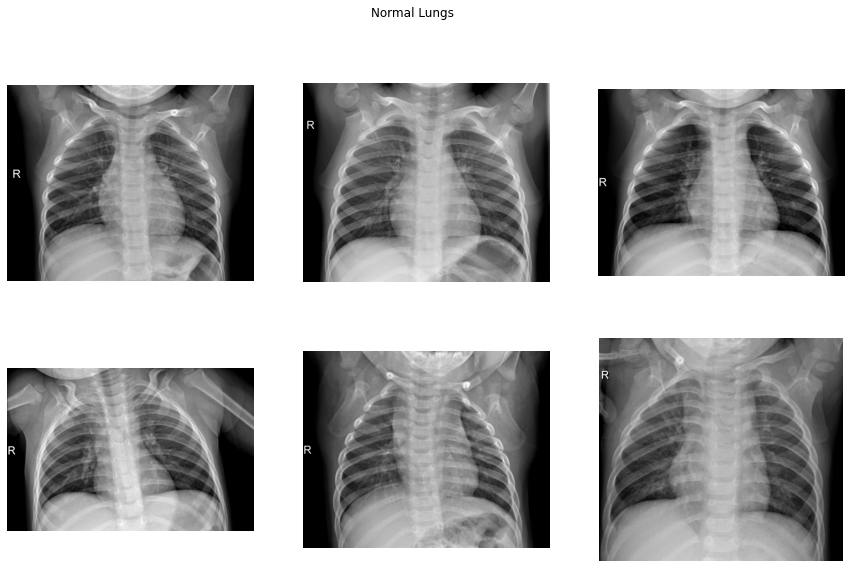

In [10]:
# 정상적인 사람의 폐사진 샘플을 보여줍니다.
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/content/chest_xray/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

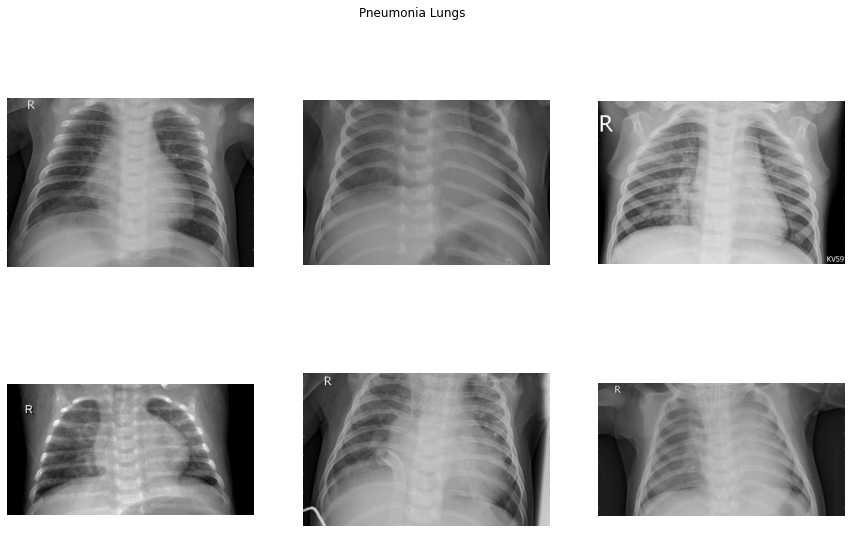

In [11]:
# 폐렴에 걸린 사람의 폐사진 샘플을 보여줍니다.
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/content/chest_xray/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

In [12]:
image_height = 150  # 이미지 높이
image_width = 150   # 이미지 넓이
batch_size = 10     # batch size
no_of_epochs  = 30  # trining 횟수

In [13]:
# create model(모델을 만듭니다)
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0

In [14]:
# ImageDataGenerator 클래스를 통해 train_datagen 인스턴스를 만듭니다.
train_datagen = ImageDataGenerator(rescale=1./255,     # 픽셀 값을 0~1 범위로 변환
                                   rotation_range=15,  # 15도까지 회전
                                   shear_range=0.2,    # 20%까지 기울임 
                                   zoom_range=0.2      # 20%까지 확대
                                   )

# ImageDataGenerator 클래스를 통해 val_datagen 인스턴스를 만듭니다
val_datagen = ImageDataGenerator(rescale=1./255)       # 픽셀 값을 0~1 범위로 변환

In [15]:
# train_datagen 인스턴스를 통해 trin dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성한다.
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성한다.
test_set = val_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

# val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성한다.
val_set = val_datagen.flow_from_directory('/content/chest_xray/val',
                                            target_size=(image_width, image_height),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [16]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/gdrive/MyDrive/Diagnose_Pneumonia/diagnose_pneumonia_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

In [17]:
# model training(모델을 학습시킵니다)
history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=[monitor_val_acc, modelCheckpoint]
                   )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
521/521 [==============================] - 94s 150ms/step - loss: 0.5862 - accuracy: 0.7418 - val_loss: 0.6932 - val_accuracy: 0.6242
Epoch 2/30
521/521 [==============================] - 78s 150ms/step - loss: 0.5764 - accuracy: 0.7430 - val_loss: 0.7001 - val_accuracy: 0.6274
Epoch 3/30
521/521 [==============================] - 77s 149ms/step - loss: 0.5749 - accuracy: 0.7428 - val_loss: 0.7210 - val_accuracy: 0.6258
Epoch 4/30
521/521 [==============================] - 78s 149ms/step - loss: 0.5742 - accuracy: 0.7426 - val_loss: 0.6685 - val_accuracy: 0.6242
Epoch 5/30
521/521 [==============================] - 78s 149ms/step - loss: 0.4870 - accuracy: 0.7764 - val_loss: 0.6662 - val_accuracy: 0.6419
Epoch 6/30
521/521 [==============================] - 78s 150ms/step - loss: 0.5030 - accuracy: 0.8014 - val_loss: 0.6583 - val_accuracy: 0.6452
Epoch 7/30
521/521 [==============================] - 78s 149ms/step - loss: 0.4262 - accuracy: 0.8127 - val_loss: 0.5746 - val_ac

In [18]:
# model evaluate(모델을 평가해 봅니다)
score = model.evaluate(test_set, steps=624//batch_size, verbose=1)
print('Val loss:', score[0])
print('Val accuracy:', score[1]*100)

62/62 [==============================] - 5s 84ms/step - loss: 0.2803 - accuracy: 0.9048
Val loss: 0.28034308552742004
Val accuracy: 90.48386812210083


In [19]:
# test_set 이 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.
print(test_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


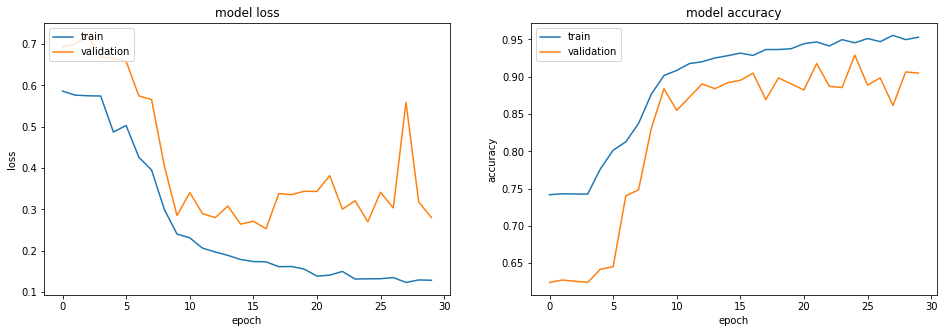

In [20]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [21]:
# val_set 이 만들어낸 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
predictions = model.predict(val_set, steps=16, verbose=1)

16/16 [==============================] - 0s 9ms/step


In [22]:
# predictions shape 확인
predictions.shape

(16, 1)

In [23]:
# val_set 이 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.
print(val_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


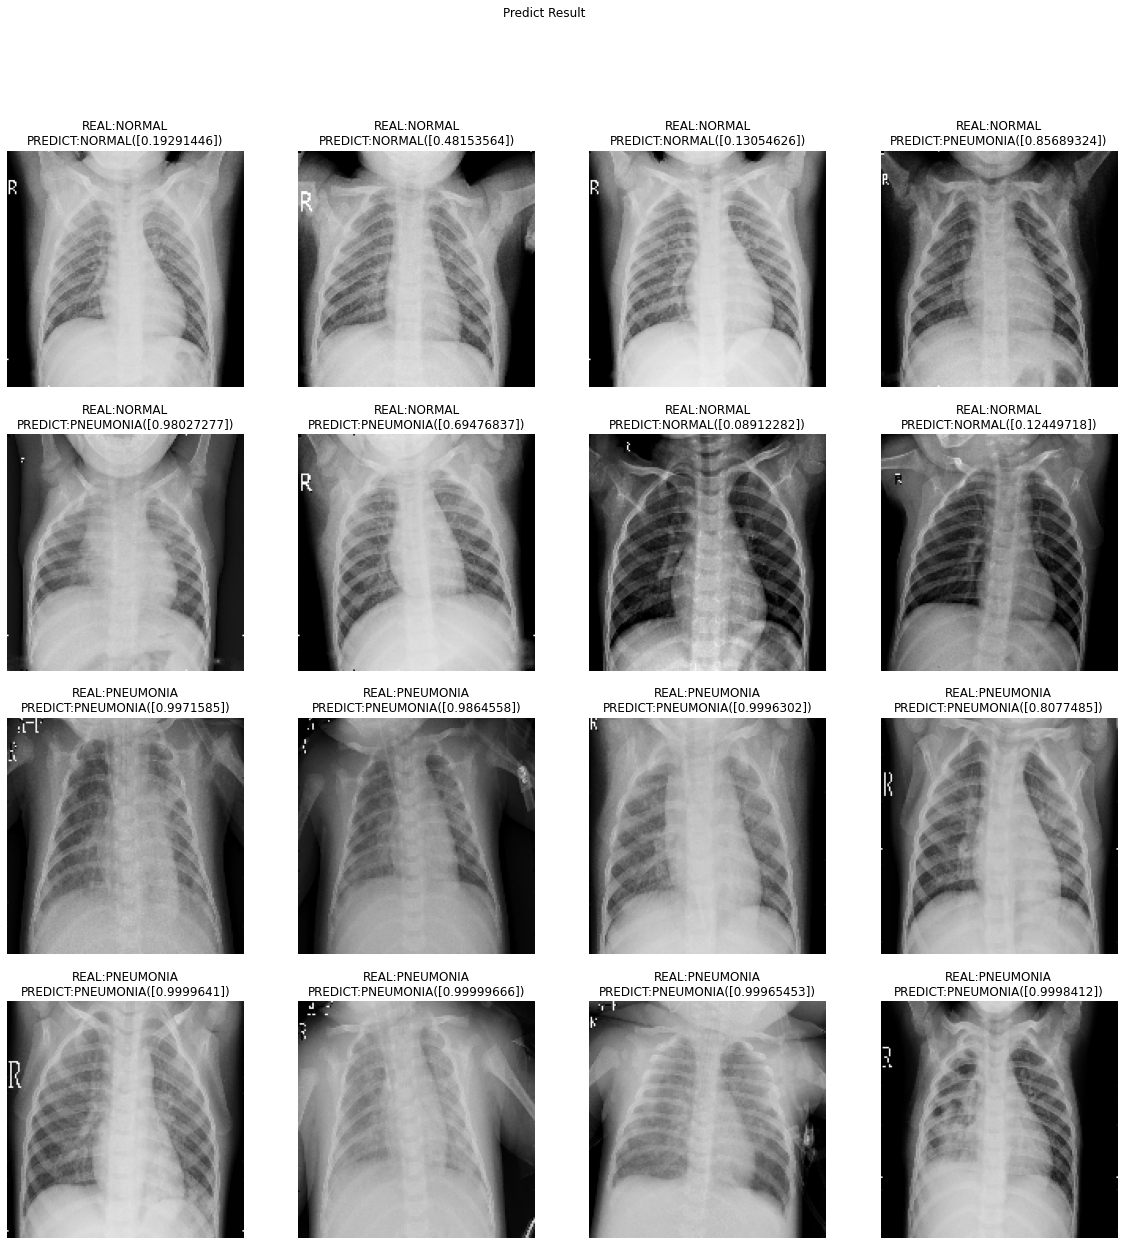

In [24]:
# Predict Result(val_set 가 만들어 낸 이미지를 우리가 만든 모델을 통해 예측한 결과를 보여줍니다.)
f,ax = plt.subplots(4,4,figsize=(20,20))

for i in range(len(predictions)):
    image, label = val_set.next()                                  # val_set 이 만들어 낸 이미지를 하나씩 꺼내온다
    real_class = 'NORMAL' if int(label) == 0 else 'PNEUMONIA'      # val_set 이 만들어 낸 이미지의 label name 을 가져옴
    ax[i//4,i%4].imshow(image[0])                                  # val_set 이 만들어 낸 이미지를 보여줌
    ax[i//4,i%4].axis('off')

    pred_class = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL' # val_set 이 만들어 낸 이미지를 모델을 통해 예측한 결과 값의 label name
    pred_prob = predictions[i]                                     # val_set 이 만들어 낸 이미지를 모델을 통해 예측한 결과(확률값)
    ax[i//4,i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class + '(' + str(pred_prob) + ')')   # title 에 실제값과 모델에 의해 예측된 예측값을 함께 보여준다.

f.suptitle('Predict Result')

plt.show()